In [1]:
# Cell: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import random


In [22]:
# Cell: Parameters
seq_length = 128
d_model = 64
nhead = 8
num_layers = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
shuffle = True
batch_size = 32

future_days = 1  # Number of future days to predict

num_bins = 64  # Number of bins for price ranges


In [23]:
# Cell: Data Loading and Preprocessing

def assign_stocks(test=False):
    if test:
        start = '2022-01-02'
        end = '2024-08-01'
        stock = 'TSLA'
    else:
        start = '1980-01-01'
        end = '2022-01-01'
        stock = '^GSPC'
    return start, end, stock

start, end, stock = assign_stocks(test=False)

# Download data
yfd = yf.download(stock, start=start, end=end)

# Use 'Close' price and normalize
df = pd.DataFrame({'Close': yfd['Close']})
prices = df['Close'].values

# For later inverse transform
mean = prices.mean()
std = prices.std()

# Normalize prices
normalized_prices = (prices - mean) / std

# Convert the data into sequences
sequences = []
for i in range(len(normalized_prices) - seq_length - future_days):
    sequences.append(normalized_prices[i:i + seq_length + future_days])

sequences = np.array(sequences)

def normalize_segment(segment_prices):
    mean = segment_prices.mean()
    std = segment_prices.std()
    return (segment_prices - mean) / std, mean, std

# Define segments (10 years each)
segments = [(start_year, start_year + 5) for start_year in range(1980, 2020, 10)]

all_sequences = []

for start_year, end_year in segments:
    segment_start = f'{start_year}-01-01'
    segment_end = f'{end_year}-01-01'

    # Download data for the 10-year segment
    yfd_segment = yf.download(stock, start=segment_start, end=segment_end)
    
    # Get 'Close' prices and normalize the segment
    segment_prices = yfd_segment['Close'].values
    normalized_prices, mean, std = normalize_segment(segment_prices)
    
    # Create sequences
    for i in range(len(normalized_prices) - seq_length - future_days):
        all_sequences.append(normalized_prices[i:i + seq_length + future_days])

# Convert all sequences to a numpy array
all_sequences = np.array(all_sequences)

sequences = all_sequences

# Split sequences into X and y
X = sequences[:, :seq_length]
y = sequences[:, seq_length:seq_length + future_days]

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Shape: [samples, seq_length, 1]
y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: [samples, future_days]

# Split data into train, val, test
original_indices = np.arange(len(X_tensor))

# Split data
x_train, x_temp, y_train, y_temp, train_indices, temp_indices = train_test_split(
    X_tensor, y_tensor, original_indices, test_size=0.3, random_state=42, shuffle=True)

x_val, x_test, y_val, y_test, val_indices, test_indices = train_test_split(
    x_temp, y_temp, temp_indices, test_size=0.5, random_state=42, shuffle=False)

print(f'Train samples: {len(x_train)}')
print(f'Validation samples: {len(x_val)}')
print(f'Test samples: {len(x_test)}')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Train samples: 3169
Validation samples: 679
Test samples: 680


In [24]:
# Cell: Define Price Bins

# Get the min and max of the target prices in training data
min_price = y_train.min().item()
max_price = y_train.max().item()

print(f"Min normalized price: {min_price}, Max normalized price: {max_price}")

# Create bins that cover the range of the prices
bin_edges = np.linspace(min_price, max_price, num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints of bins
bin_width = (max_price - min_price) / num_bins


Min normalized price: -2.289689779281616, Max normalized price: 2.114518165588379


In [25]:
# Cell: Apply Smoothing to Prices

# Function to smooth the prices (e.g., using a simple moving average)
def smooth_prices(prices, window_size=3):
    smoothed_prices = np.convolve(prices, np.ones(window_size) / window_size, mode='valid')
    return np.concatenate((prices[:window_size-1], smoothed_prices))

"""
# Apply smoothing to training, validation, and test targets
y_train_smoothed = np.apply_along_axis(smooth_prices, 1, y_train.numpy())
y_val_smoothed = np.apply_along_axis(smooth_prices, 1, y_val.numpy())
y_test_smoothed = np.apply_along_axis(smooth_prices, 1, y_test.numpy())
"""
y_train_smoothed = y_train
y_val_smoothed = y_val
y_test_smoothed = y_test

# Convert back to torch tensors
y_train_smoothed = torch.tensor(y_train_smoothed, dtype=torch.float32)
y_val_smoothed = torch.tensor(y_val_smoothed, dtype=torch.float32)
y_test_smoothed = torch.tensor(y_test_smoothed, dtype=torch.float32)

# Cell: Update Target Bins with Smoothed Targets

# Function to map price to bin index
def price_to_bin(price, bin_edges):
    # price: Tensor of shape [batch_size, future_days]
    # bin_edges: array of shape [num_bins + 1]
    # returns bin_indices: Tensor of same shape as price, with bin indices
    bin_indices = np.digitize(price.cpu().numpy(), bin_edges) - 1  # Subtract 1 to get indices from 0
    bin_indices = np.clip(bin_indices, 0, len(bin_edges) - 2)  # Ensure indices are within valid range
    return torch.tensor(bin_indices, dtype=torch.long, device=price.device)

# Map smoothed targets to bin indices
y_train_bins = price_to_bin(y_train_smoothed, bin_edges)
y_val_bins = price_to_bin(y_val_smoothed, bin_edges)
y_test_bins = price_to_bin(y_test_smoothed, bin_edges)

# Cell: Update Target Bins with Label Smoothing

def smooth_labels(y_bins, num_bins, smoothing=0.1):
    """
    y_bins: Tensor of shape [batch_size, future_days], containing bin indices (integer values)
    num_bins: int, number of bins
    smoothing: float, smoothing factor to apply (default = 0.1)
    """

    confidence = 1.0 - smoothing
    smoothing_value = smoothing / (num_bins - 1)

    # Create a tensor filled with smoothing_value for all bins
    smoothed_labels = torch.full((y_bins.size(0), y_bins.size(1), num_bins), smoothing_value, device=y_bins.device)

    # For each target bin, assign the 'confidence' value to the correct bin
    y_bins_unsqueezed = y_bins.unsqueeze(-1)  # Shape: [batch_size, future_days, 1]
    smoothed_labels.scatter_(-1, y_bins_unsqueezed, confidence)  # Assign confidence value to the correct bin

    return smoothed_labels  # Shape: [batch_size, future_days, num_bins]

# Apply label smoothing
smoothing = 0.1  # You can adjust this value as needed
y_train_smooth_labels = smooth_labels(y_train_bins, num_bins=num_bins, smoothing=smoothing)
y_val_smooth_labels = smooth_labels(y_val_bins, num_bins=num_bins, smoothing=smoothing)
y_test_smooth_labels = smooth_labels(y_test_bins, num_bins=num_bins, smoothing=smoothing)

print(y_train_smooth_labels.shape)


torch.Size([3169, 1, 64])


C:\Users\mehur\AppData\Local\Temp\ipykernel_25740\4272219024.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_smoothed = torch.tensor(y_train_smoothed, dtype=torch.float32)
C:\Users\mehur\AppData\Local\Temp\ipykernel_25740\4272219024.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_smoothed = torch.tensor(y_val_smoothed, dtype=torch.float32)
C:\Users\mehur\AppData\Local\Temp\ipykernel_25740\4272219024.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_smoothed = torch.tensor(y_test_smoothed, dtype=torch.floa

In [26]:
# Create TensorDatasets with smoothed labels and actual prices
train_dataset = TensorDataset(x_train, y_train_smooth_labels, y_train)
val_dataset = TensorDataset(x_val, y_val_smooth_labels, y_val)
test_dataset = TensorDataset(x_test, y_test_smooth_labels, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [27]:
class FinancialWaveTransformerBins(nn.Module):
    def __init__(self, seq_length, d_model, nhead, num_layers, num_bins, future_days=16, dropout=0.5, bin_width=0.01):
        super(FinancialWaveTransformerBins, self).__init__()
        self.embedding = nn.Linear(1, d_model)
        self.pos_encoder = nn.Embedding(seq_length + future_days, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(d_model, 2 * num_bins)  # Output real and imaginary parts for each bin

        self.future_days = future_days
        self.num_bins = num_bins
        self.bin_width = bin_width
        self.seq_length = seq_length  # Save sequence length for rolling window

    def forward(self, x):
        batch_size = x.size(0)
        device = x.device

        # Initialize lists for predictions
        price_predictions = []
        prob_dist_predictions = []
        phase_predictions = []

        # Encode the input sequence
        x_embedded = self.embedding(x)  # Shape: [batch_size, seq_length, d_model]
        positions = torch.arange(self.seq_length, device=device).unsqueeze(0).expand(batch_size, self.seq_length)
        x_embedded = x_embedded + self.pos_encoder(positions)  # [batch_size, seq_length, d_model]
        x_embedded = x_embedded.transpose(0, 1)  # [seq_length, batch_size, d_model]
        memory = self.transformer_encoder(x_embedded)  # [seq_length, batch_size, d_model]

        # Get the final state from the transformer
        memory = memory[-1, :, :]  # Use the final state from the transformer [batch_size, d_model]

        for t in range(self.future_days):
            # Positional encoding for the future day
            position = self.seq_length + t
            future_position = torch.full((batch_size,), position, device=device, dtype=torch.long)  # [batch_size]
            pos_embedding = self.pos_encoder(future_position)  # [batch_size, d_model]

            # Add positional encoding to memory
            memory_with_pos = memory + pos_embedding  # [batch_size, d_model]

            output = self.dropout(memory_with_pos)

            # Quantum-inspired computations
            out = self.fc_out(output)  # [batch_size, 2 * num_bins]
            real = out[:, :self.num_bins] + 1e-8  # [batch_size, num_bins]
            imaginary = out[:, self.num_bins:]  # [batch_size, num_bins]

            # Compute phase and magnitude
            phase = torch.atan2(imaginary, real)  # [batch_size, num_bins]
            phase_factor = phase / torch.pi  # Normalize between -1 and 1

            magnitude_squared = real**2 + imaginary**2  # [batch_size, num_bins]
            probability_distribution = magnitude_squared / (1e-8 + magnitude_squared.sum(dim=1, keepdim=True))  # [batch_size, num_bins]

            # Append probability distributions and phase factors
            prob_dist_predictions.append(probability_distribution.unsqueeze(1))  # [batch_size, 1, num_bins]
            phase_predictions.append(phase_factor.unsqueeze(1))  # [batch_size, 1, num_bins]

            # Predict bins for this time step
            predicted_bins = torch.argmax(probability_distribution, dim=1)  # [batch_size]

            # Convert predicted bins to bin centers
            bin_centers_tensor = torch.tensor(bin_centers, device=device).float()  # [num_bins]
            selected_bin_centers = bin_centers_tensor[predicted_bins]  # [batch_size]

            # Predicted price is bin center plus adjusted phase factor
            predicted_price = selected_bin_centers + self.bin_width 

            # Update memory with the predicted price (auto-regression)
            predicted_price = predicted_price.unsqueeze(1).unsqueeze(-1)  # [batch_size, 1, 1] - add time and feature dimensions
            x = torch.cat([x[:, 1:, :], predicted_price], dim=1)  # Shift sequence and append the new predicted price
            
            # Recompute transformer memory with updated sequence
            x_embedded = self.embedding(x)  # [batch_size, seq_length, d_model]
            positions = torch.arange(self.seq_length, device=device).unsqueeze(0).expand(batch_size, self.seq_length)
            x_embedded = x_embedded + self.pos_encoder(positions)  # [batch_size, seq_length, d_model]
            x_embedded = x_embedded.transpose(0, 1)  # [seq_length, batch_size, d_model]
            memory = self.transformer_encoder(x_embedded)  # [seq_length, batch_size, d_model]
            memory = memory[-1, :, :]  # Update memory with final transformer state

            # Append predicted price to the list of price predictions
            price_predictions.append(predicted_price.squeeze(-1).squeeze(1))  # [batch_size]

        # Stack all future price predictions
        price_predictions = torch.stack(price_predictions, dim=1)  # [batch_size, future_days]
        prob_dist_predictions = torch.cat(prob_dist_predictions, dim=1)  # [batch_size, future_days, num_bins]
        phase_predictions = torch.cat(phase_predictions, dim=1)  # [batch_size, future_days, num_bins]

        return price_predictions, prob_dist_predictions, phase_predictions


In [28]:
# Cell: Instantiate Model

# Initialize the model
model = FinancialWaveTransformerBins(seq_length=seq_length,
                                     d_model=d_model,
                                     nhead=nhead,
                                     num_layers=num_layers,
                                     num_bins=num_bins,
                                     future_days=future_days, bin_width=bin_width).to(device)


C:\Users\mehur\anaconda3\envs\pytorch_cuda\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [29]:
# Cell: Define Loss Function (with shape debug)

def quantum_loss(prob_dist_predictions, smoothed_targets):
    # Ensure inputs are floating-point numbers
    prob_dist_predictions = prob_dist_predictions.float()
    smoothed_targets = smoothed_targets.float()

    # Log of predicted probabilities for KL divergence
    log_prob_dist_predictions = torch.log(prob_dist_predictions + 1e-8)

    # Compute KL divergence between the predicted probabilities and smoothed targets
    loss = F.kl_div(log_prob_dist_predictions, smoothed_targets, reduction='batchmean')

    return loss


In [30]:
# Cell: Training Loop with Cross-Entropy Loss

criterion_mse = nn.MSELoss()
alpha = 1  # Weight for the MSE loss

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

train_losses = []
val_losses = []

num_epochs = 512

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    for i, (inputs, target_smooth_labels, target_prices) in enumerate(train_loader):
        inputs = inputs.to(device)
        target_smooth_labels = target_smooth_labels.to(device)
        target_prices = target_prices.to(device)  # Actual target prices
        optimizer.zero_grad()

        predicted_prices, prob_dist_predictions, phase_predictions = model(inputs)

        # Compute quantum loss
        loss_quantum = quantum_loss(prob_dist_predictions, target_smooth_labels)

        # Compute MSE loss
        loss_mse = criterion_mse(predicted_prices, target_prices)

        # Total loss
        loss = loss_quantum + alpha * loss_mse

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate and store average training loss for the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, target_smooth_labels, target_prices in val_loader:
            inputs = inputs.to(device)
            target_smooth_labels = target_smooth_labels.to(device)
            target_prices = target_prices.to(device)  # Actual target prices

            predicted_prices, prob_dist_predictions, phase_predictions = model(inputs)

            # Compute quantum loss
            loss_quantum = quantum_loss(prob_dist_predictions, target_smooth_labels)

            # Compute MSE loss
            loss_mse = criterion_mse(predicted_prices, target_prices)

            # Total loss
            loss = loss_quantum + alpha * loss_mse

            val_running_loss += loss.item()

    # Calculate and store average validation loss for the epoch
    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print the training and validation losses
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')


Epoch [1/512], Training Loss: 4.7898, Validation Loss: 3.3461
Epoch [2/512], Training Loss: 3.7228, Validation Loss: 3.0561
Epoch [3/512], Training Loss: 3.2609, Validation Loss: 2.8151
Epoch [4/512], Training Loss: 3.0100, Validation Loss: 2.6823
Epoch [5/512], Training Loss: 2.8360, Validation Loss: 2.5869
Epoch [6/512], Training Loss: 2.7266, Validation Loss: 2.4842
Epoch [7/512], Training Loss: 2.6034, Validation Loss: 2.3948
Epoch [8/512], Training Loss: 2.5660, Validation Loss: 2.2224
Epoch [9/512], Training Loss: 2.4486, Validation Loss: 2.1670
Epoch [10/512], Training Loss: 2.3943, Validation Loss: 2.1379
Epoch [11/512], Training Loss: 2.2917, Validation Loss: 2.1025
Epoch [12/512], Training Loss: 2.2707, Validation Loss: 2.0424
Epoch [13/512], Training Loss: 2.2017, Validation Loss: 2.0024
Epoch [14/512], Training Loss: 2.1493, Validation Loss: 1.9720
Epoch [15/512], Training Loss: 2.1371, Validation Loss: 1.9469
Epoch [16/512], Training Loss: 2.0946, Validation Loss: 1.9382
E

KeyboardInterrupt: 

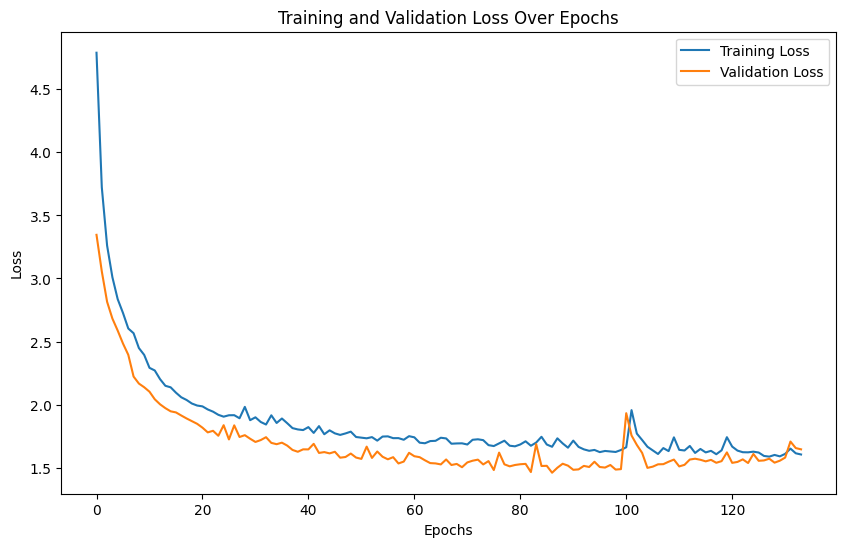

In [31]:
# Cell: Plot Training and Validation Loss

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [32]:
# Cell: Evaluation on Test Set

model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs, target_bins, target_prices in test_loader:
        inputs = inputs.to(device)
        target_bins = target_bins.to(device)
        target_prices = target_prices.to(device)  # Smoothed target prices

        predicted_prices, prob_dist_predictions, phase_predictions = model(inputs)

        # Compute quantum loss
        loss_quantum = quantum_loss(prob_dist_predictions, target_bins)

        # Compute MSE loss
        loss_mse = criterion_mse(predicted_prices, target_prices)

        # Total loss
        loss = loss_quantum + alpha * loss_mse

        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}')


Test Loss: 1.6006


In [33]:
# Corrected Evaluation on the test set
model.eval()
predicted_prices = []
actual_prices = []

with torch.no_grad():
    for inputs, _, target_prices in test_loader:
        inputs = inputs.to(device)
        target_prices = target_prices.to(device)
        # Perform prediction without modifying the inputs
        predicted_price, probability_distribution, phase_factor = model(inputs)

        # Store predictions and actual prices
        predicted_prices.append(predicted_price.cpu().numpy())
        actual_prices.append(target_prices.cpu().numpy())

# Convert lists to numpy arrays
predicted_prices = np.concatenate(predicted_prices, axis=0)
actual_prices = np.concatenate(actual_prices, axis=0)

# Rescale the predicted and actual prices to their original scale
predicted_prices = predicted_prices * std + mean
actual_prices = actual_prices * std + mean

# The rest of your plotting code remains the same


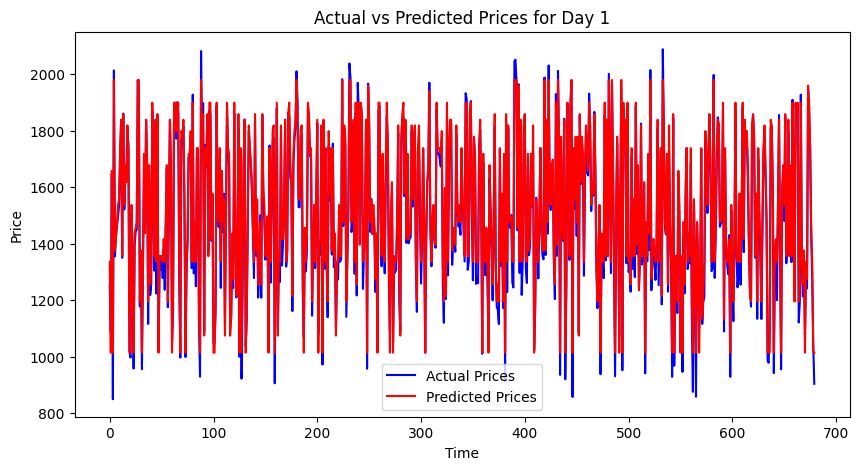

In [34]:
# Cell: Plot Actual vs Predicted Prices for Day 1

# Assuming `actual_prices` and `predicted_prices` are of shape [samples, future_days]
day_index = 0  # Day to plot

plt.figure(figsize=(10, 5))
plt.plot(actual_prices[:, day_index], label='Actual Prices', color='blue')
plt.plot(predicted_prices[:, day_index], label='Predicted Prices', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Actual vs Predicted Prices for Day {day_index + 1}')
plt.legend()
plt.show()


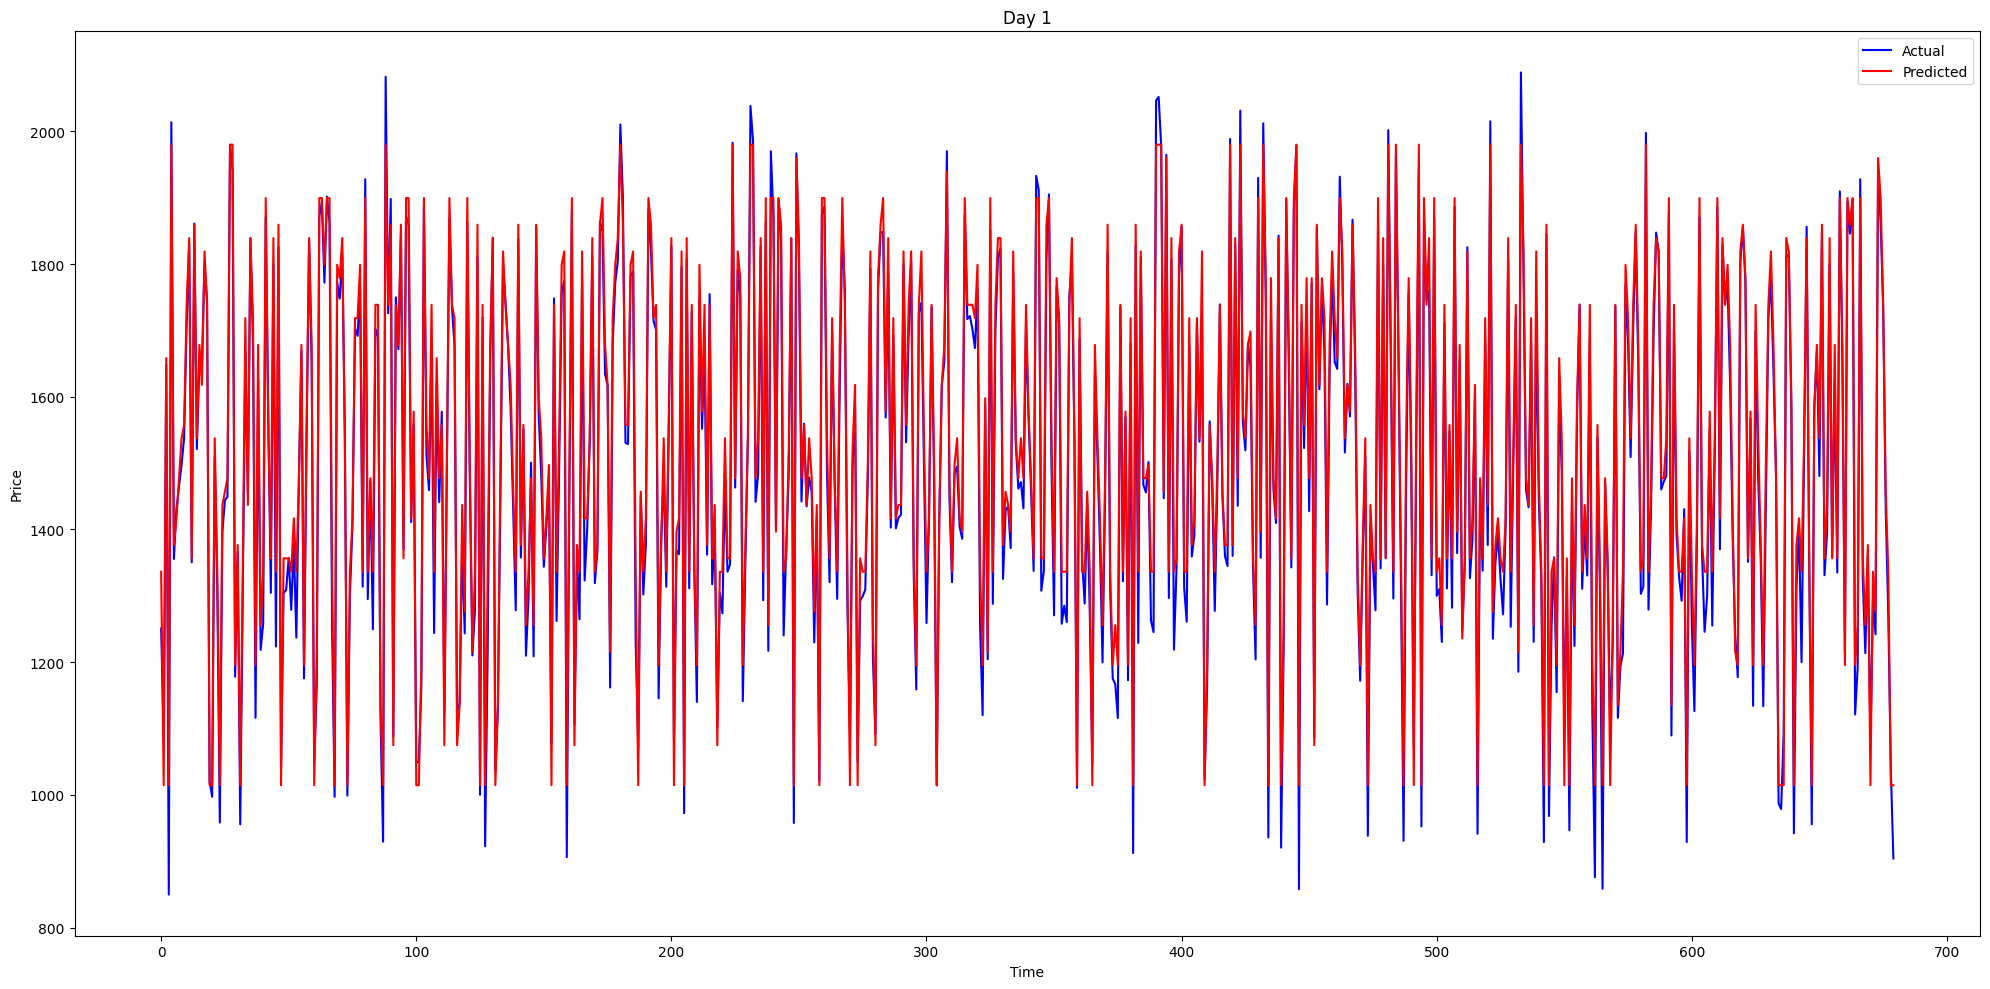

In [35]:
# Cell 16: Plot Actual vs Predicted Prices for All Future Days

# Plot the actual vs predicted prices for each future day
rows = 1
cols = 1
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))

ax = axes
ax.plot(actual_prices[:, day_index], label='Actual', color='blue')
ax.plot(predicted_prices[:, day_index], label='Predicted', color='red')
ax.set_title(f'Day {day_index + 1}')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.legend()

plt.tight_layout()
plt.show()


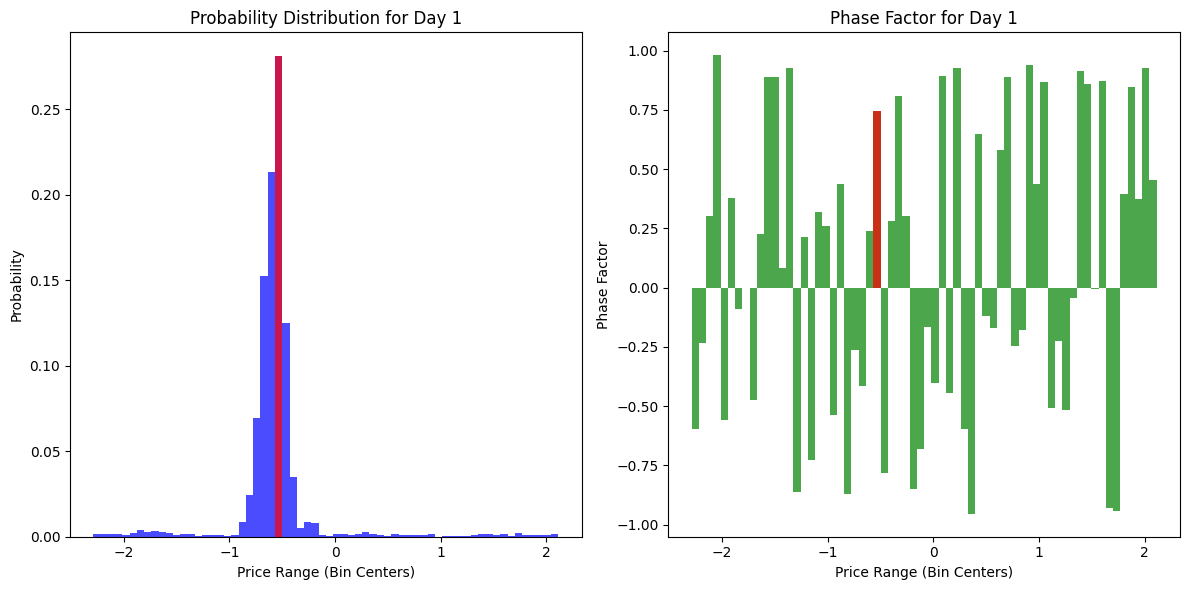

In [36]:
# Cell 17: Visualize Probability Distribution and Phase Factor

def visualize_choice(bin_centers, probability_distribution, phase_factor, most_probable_bin, day_index=0):
    plt.figure(figsize=(12, 6))

    # Plot the probability distribution for the selected day
    plt.subplot(1, 2, 1)
    plt.bar(bin_centers, probability_distribution, color='b', alpha=0.7, width=bin_width)
    plt.xlabel('Price Range (Bin Centers)')
    plt.ylabel('Probability')
    plt.title(f'Probability Distribution for Day {day_index + 1}')

    # Plot the phase factor for the selected day
    plt.subplot(1, 2, 2)
    plt.bar(bin_centers, phase_factor, color='g', alpha=0.7, width=bin_width)
    plt.xlabel('Price Range (Bin Centers)')
    plt.ylabel('Phase Factor')
    plt.title(f'Phase Factor for Day {day_index + 1}')

    # Highlight the chosen bin on both plots
    plt.subplot(1, 2, 1)
    plt.bar(bin_centers[most_probable_bin],
            probability_distribution[most_probable_bin],
            color='r', alpha=0.7, width=bin_width)

    plt.subplot(1, 2, 2)
    plt.bar(bin_centers[most_probable_bin],
            phase_factor[most_probable_bin],
            color='r', alpha=0.7, width=bin_width)

    plt.tight_layout()
    plt.show()

with torch.no_grad():
    for inputs, _, _ in test_loader:
        inputs = inputs.to(device)
        predicted_prices, prob_dist_predictions, phase_predictions = model(inputs)
        bin_centers_tensor = torch.tensor(bin_centers, device=device).float()  # [num_bins]

        # Select the first sample and first future day
        sample_index = 0
        day_index = 0  # Change this to visualize different future days

        # Extract data for the selected sample and day
        prob_dist_sample = prob_dist_predictions[sample_index, day_index].cpu().numpy()
        phase_factor_sample = phase_predictions[sample_index, day_index].cpu().numpy()
        most_probable_bin = torch.argmax(prob_dist_predictions[sample_index, day_index]).item()

        # Visualize
        visualize_choice(bin_centers,
                         prob_dist_sample,
                         phase_factor_sample,
                         most_probable_bin,
                         day_index=day_index)

        break  # Visualize for one batch (first sample)


In [37]:
# Specify the subset of days you want to display
# For example, let's display only the first 5 days of the test set
subset_days = 1  # Modify this value to show more or fewer days
subset_indices = range(subset_days)

predicted_prices = predicted_prices * std + mean

# Create a DataFrame for easier viewing
days = [f"Day {i+1}" for i in subset_indices]
actual_prices_subset_df = pd.DataFrame(actual_prices[:, subset_indices], columns=days)
predicted_prices_subset_df = pd.DataFrame(predicted_prices[:, subset_indices].cpu(), columns=days)

# Display the actual and predicted prices for the subset of days
sorted_actual_prices_subset_df = actual_prices_subset_df.sort_index(axis=1)
sorted_predicted_prices_subset_df = predicted_prices_subset_df.sort_index(axis=1)

# Display the sorted DataFrames for the subset
print("Sorted Actual Prices (Subset):")
display(sorted_actual_prices_subset_df)

print("Sorted Predicted Prices (Subset):")
display(sorted_predicted_prices_subset_df)


Sorted Actual Prices (Subset):


,Day 1
0,1250.779332
1,1088.686875
2,1648.280107
3,849.715736
4,2013.758005
...,...
675,1733.150024
676,1430.738595
677,1271.732298
678,1038.146292


Sorted Predicted Prices (Subset):


,Day 1
0,1336.359009
1,1014.562256
2,1658.155762
3,1014.562256
4,1979.952393
5,1376.583618
6,1416.808228
7,1477.145020
8,1537.481934
9,1557.594238


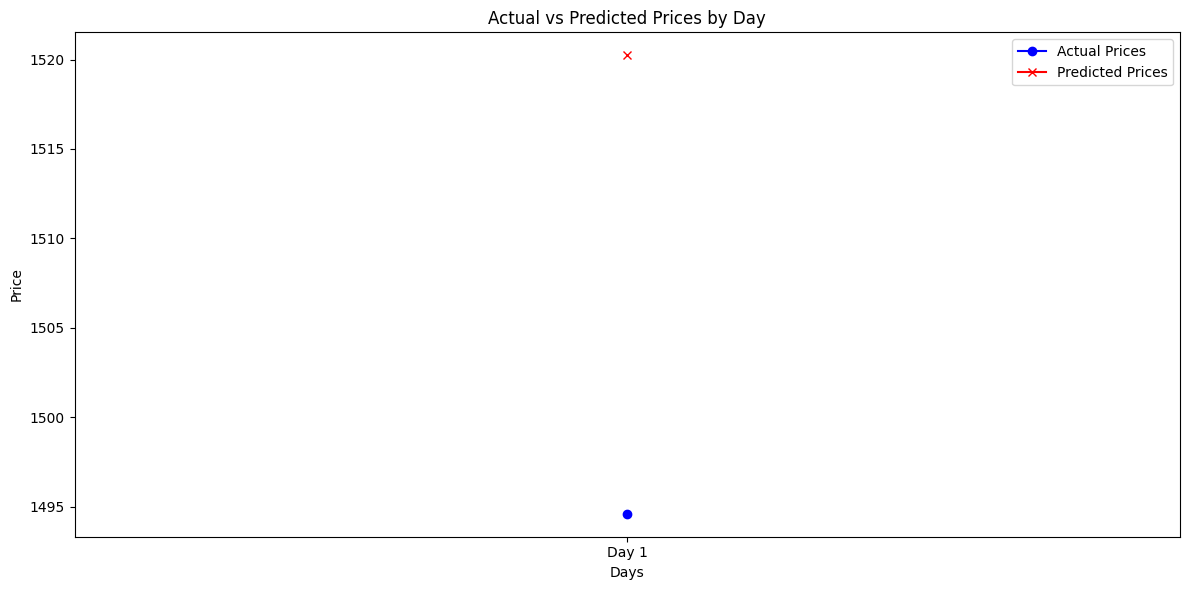

In [38]:
# Evaluation on the test set
model.eval()
predicted_prices = []
actual_prices = []

with torch.no_grad():
    for inputs, _, target_prices in test_loader:
        inputs = inputs.to(device)
        target_prices = target_prices.to(device)
        predicted_price, _, _ = model(inputs)

        predicted_prices.append(predicted_price.cpu().numpy())
        actual_prices.append(target_prices.cpu().numpy())

predicted_prices = np.concatenate(predicted_prices, axis=0)
actual_prices = np.concatenate(actual_prices, axis=0)

# Rescale to original scale
predicted_prices = predicted_prices * std + mean
actual_prices = actual_prices * std + mean

# Create DataFrames
days = [f"Day {i+1}" for i in range(future_days)]
actual_prices_df = pd.DataFrame(actual_prices, columns=days)
predicted_prices_df = pd.DataFrame(predicted_prices, columns=days)

# Plot actual vs predicted prices by day
plt.figure(figsize=(12, 6))
plt.plot(actual_prices_df.mean(), label='Actual Prices', color='blue', marker='o')
plt.plot(predicted_prices_df.mean(), label='Predicted Prices', color='red', marker='x')
plt.title('Actual vs Predicted Prices by Day')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


Sorted Actual vs Predicted Prices for Day 1:


,Actual Prices (Day 1),Predicted Prices (Day 1)
0,849.715736,1014.562227
1,857.825341,1014.562227
2,858.540825,1014.562227
3,875.833539,1014.562227
4,904.157754,1014.562227
...,...,...
675,2038.260012,1979.952410
676,2046.555700,1979.952410
677,2051.800060,1979.952410
678,2082.169932,1979.952410


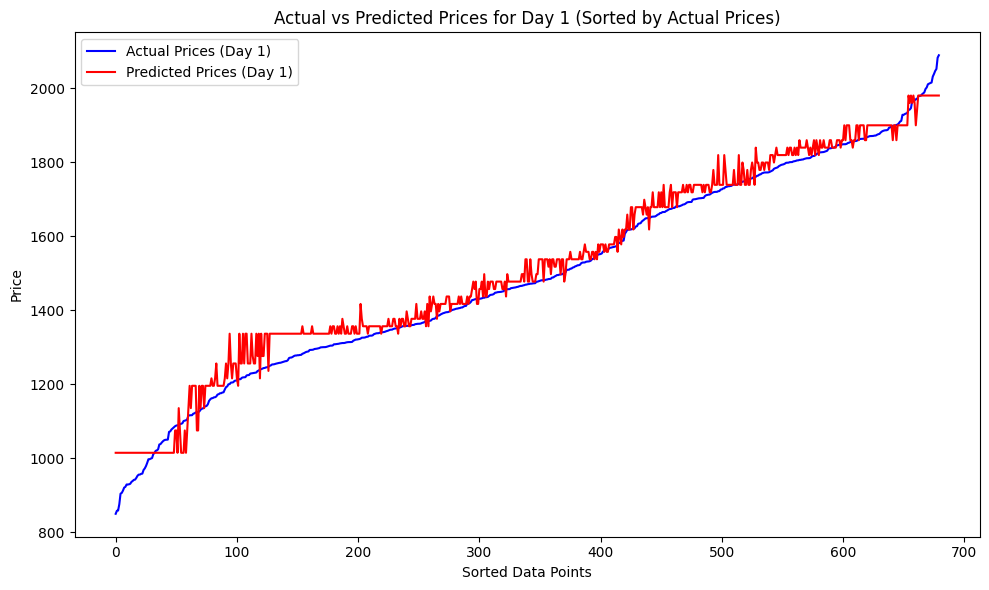

In [39]:
# Evaluation on the test set (focus on the first day)
model.eval()
predicted_prices = []
actual_prices = []

with torch.no_grad():
    for inputs, _, target_prices in test_loader:
        inputs = inputs.to(device)
        target_prices = target_prices.to(device)
        predicted_price, _, _ = model(inputs)

        predicted_prices.append(predicted_price.cpu().numpy())
        actual_prices.append(target_prices.cpu().numpy())

predicted_prices = np.concatenate(predicted_prices, axis=0)
actual_prices = np.concatenate(actual_prices, axis=0)

# Rescale to original scale
predicted_prices = predicted_prices * std + mean
actual_prices = actual_prices * std + mean

# Focus on the first day (index 0)
actual_prices_day1 = actual_prices[:, 0]  # First day actual prices
predicted_prices_day1 = predicted_prices[:, 0]  # First day predicted prices

# Sort both the actual and predicted prices by actual prices
sorted_indices = np.argsort(actual_prices_day1)
sorted_actual_prices_day1 = actual_prices_day1[sorted_indices]
sorted_predicted_prices_day1 = predicted_prices_day1[sorted_indices]

# Create a DataFrame for easier viewing
df = pd.DataFrame({
    'Actual Prices (Day 1)': sorted_actual_prices_day1,
    'Predicted Prices (Day 1)': sorted_predicted_prices_day1
})

# Display the sorted DataFrame
print("Sorted Actual vs Predicted Prices for Day 1:")
display(df)

# Plot the sorted actual vs predicted prices for Day 1
plt.figure(figsize=(10, 6))
plt.plot(sorted_actual_prices_day1, label='Actual Prices (Day 1)', color='blue')
plt.plot(sorted_predicted_prices_day1, label='Predicted Prices (Day 1)', color='red')
plt.title('Actual vs Predicted Prices for Day 1 (Sorted by Actual Prices)')
plt.xlabel('Sorted Data Points')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
# Define the subset range (for example, the first 50 points)
subset_size = 50  # You can modify this value as needed
start_time = 250
subset_sorted_actual_prices_day1 = sorted_actual_prices_day1[start_time:start_time + subset_size]
subset_sorted_predicted_prices_day1 = sorted_predicted_prices_day1[start_time:start_time + subset_size]

# Create a DataFrame for easier viewing of the subset
df_subset = pd.DataFrame({
    'Actual Prices (Day 1)': subset_sorted_actual_prices_day1,
    'Predicted Prices (Day 1)': subset_sorted_predicted_prices_day1
})

# Display the subset DataFrame
print(f"Sorted Actual vs Predicted Prices for Day 1 (Subset of {subset_size} points):")
display(df_subset)


Sorted Actual vs Predicted Prices for Day 1 (Subset of 50 points):


,Actual Prices (Day 1),Predicted Prices (Day 1)
0,1363.087235,1376.583567
1,1363.359844,1376.583567
2,1364.329959,1396.695850
3,1365.986885,1376.583567
4,1366.528532,1376.583567
5,1368.794494,1396.695850
6,1369.808291,1356.471267
7,1370.260006,1416.808155
8,1370.821896,1356.471267
9,1371.033987,1436.920447


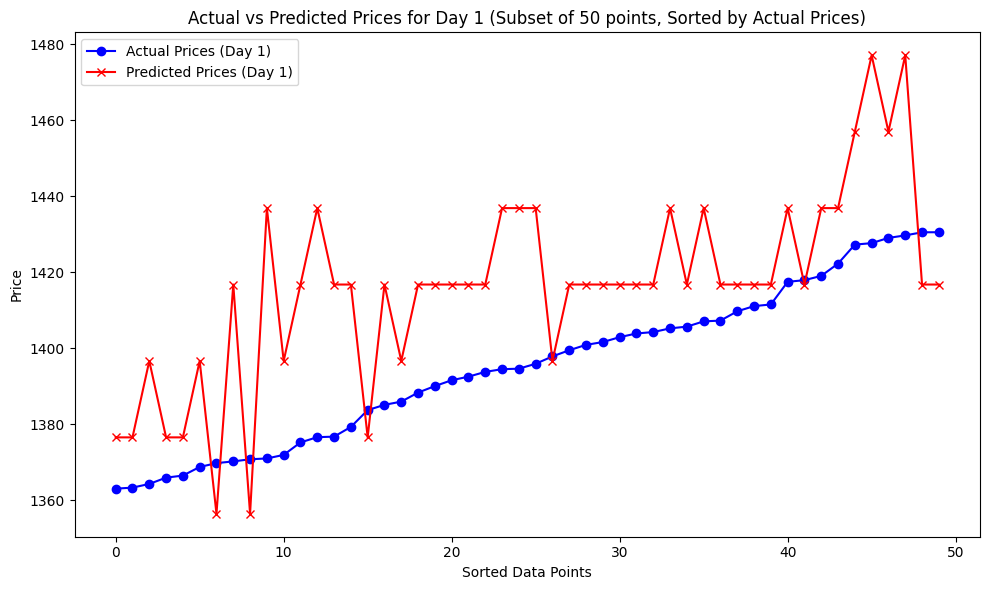

In [41]:
# Plot the sorted actual vs predicted prices for the subset
plt.figure(figsize=(10, 6))
plt.plot(subset_sorted_actual_prices_day1, label='Actual Prices (Day 1)', color='blue', marker='o')
plt.plot(subset_sorted_predicted_prices_day1, label='Predicted Prices (Day 1)', color='red', marker='x')
plt.title(f'Actual vs Predicted Prices for Day 1 (Subset of {subset_size} points, Sorted by Actual Prices)')
plt.xlabel('Sorted Data Points')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()